In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer   # 결측치값 대체.
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

na_values_df = pd.read_csv("../data/final_dataset.csv")
na_values_df.info()


X = na_values_df.drop(columns='target').values
# X = X.astype('float32')
y = na_values_df['target'].values
y = y.astype(int)

X.shape,  y.shape

fe_transformer = ColumnTransformer([
    ("category_ohe", OneHotEncoder(), [0, 1, 3, 4, 5, 6, 7, 8, 10]),
    ("number_scaler", StandardScaler(), [9,11,12,13,14])
])
### DataFrame이 입력일 경우 컬럼명이나 컬럼 index를 지정할 수 있다.
### ndarray가 입력일 경우 컬럼(feature) index를 지정.
new_merged_df = fe_transformer.fit_transform(X)

X = new_merged_df
X = X.astype('float32')
X = X.toarray()
# y = new_merged_df['target'].values
y = y.astype(int)
X.shape,  y.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32545 entries, 0 to 32544
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32545 non-null  object 
 1   code_presentation     32545 non-null  object 
 2   id_student            32545 non-null  int64  
 3   gender                32545 non-null  object 
 4   region                32545 non-null  object 
 5   highest_education     32545 non-null  int64  
 6   imd_band              32545 non-null  float64
 7   age_band              32545 non-null  int64  
 8   num_of_prev_attempts  32545 non-null  int64  
 9   studied_credits       32545 non-null  int64  
 10  disability            32545 non-null  object 
 11  date_registration     32545 non-null  float64
 12  date_unregistration   32545 non-null  float64
 13  sum_click             32545 non-null  float64
 14  avg_score             32545 non-null  float64
 15  target             

((32545, 58), (32545,))


 >>> Tuning MLPClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:12.95233초
[✔] 전체 모델과 지표가 저장되었습니다: ../model/all_models.pkl

=== Final Comparison ===
        Model                                                                                                           Best Params  Train Accuracy (CV)  Test Accuracy
MLPClassifier {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (50, 30), 'learning_rate_init': 0.001}             0.896067       0.900446


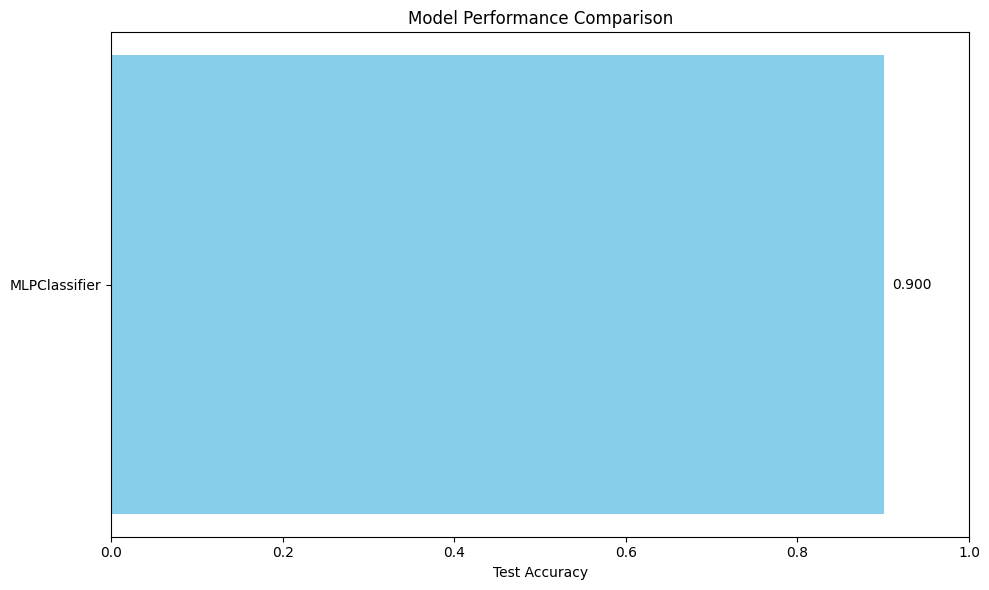


 MLPClassifier Best Model Report
              precision    recall  f1-score   support

           0    0.85791   0.94437   0.89907      3056
           1    0.94595   0.86157   0.90179      3453

    accuracy                        0.90045      6509
   macro avg    0.90193   0.90297   0.90043      6509
weighted avg    0.90461   0.90045   0.90051      6509



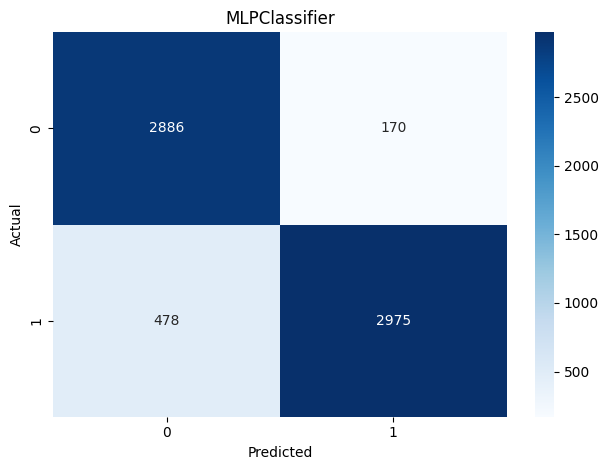

In [ ]:
import sys
import optuna
from pathlib import Path
# 상위 폴더를 Python 경로에 추가
sys.path.append(str(Path.cwd().parent))
from util.model_tuning import auto_model_tuning
from util.model_io import save_model, load_model, save_models, load_models
from sklearn.preprocessing import StandardScaler


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier

base_models = {"MLPClassifier": MLPClassifier(max_iter=1000, early_stopping=True, random_state=42)}
param_grids = {
    "MLPClassifier": {
        'hidden_layer_sizes': [(50,30)],
        'activation': ['tanh',''],
        'alpha': [0.001],  # L2 규제 강도
        'learning_rate_init': [0.001],
        'batch_size': [64]
    }
}
# 함수 실행
results_df, best_models = auto_model_tuning(base_models, param_grids, X, y)


 >>> Tuning stack_model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:216.57515초
[✔] 전체 모델과 지표가 저장되었습니다: ../model/all_models.pkl

=== Final Comparison ===
      Model                                                                                                                                                                Best Params  Train Accuracy (CV)  Test Accuracy
stack_model {'final_estimator__C': 0.1, 'mlp__activation': 'tanh', 'mlp__alpha': 0.05, 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (60, 30), 'mlp__learning_rate_init': 0.0005}              0.89914        0.89937


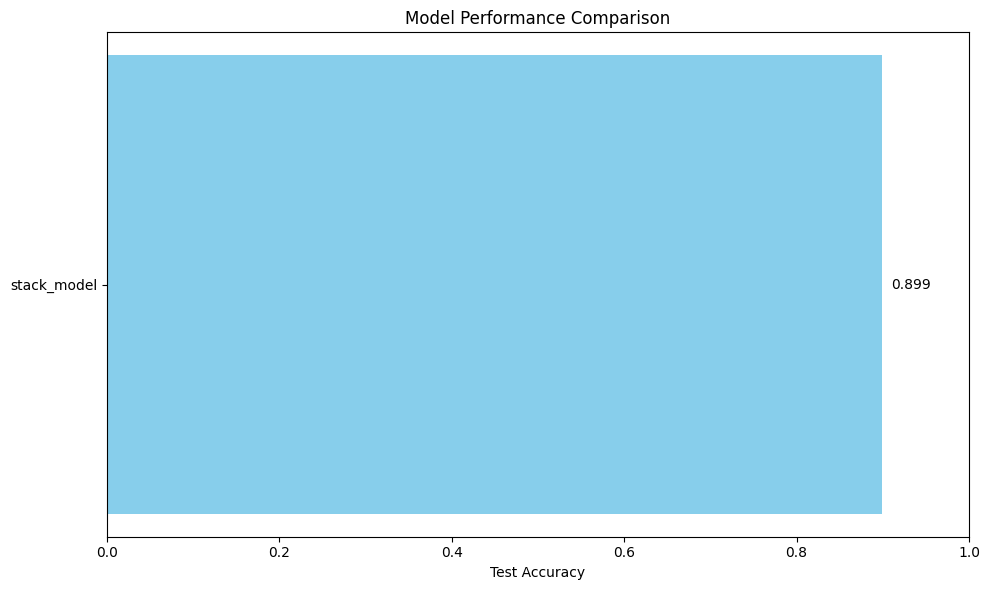


 stack_model Best Model Report
              precision    recall  f1-score   support

           0    0.87225   0.92048   0.89572      3056
           1    0.92600   0.88068   0.90278      3453

    accuracy                        0.89937      6509
   macro avg    0.89913   0.90058   0.89925      6509
weighted avg    0.90077   0.89937   0.89946      6509



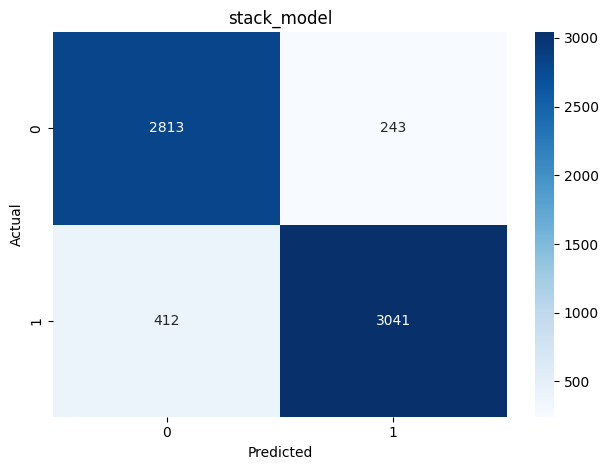

In [10]:
import sys
import optuna
from pathlib import Path
# 상위 폴더를 Python 경로에 추가
sys.path.append(str(Path.cwd().parent))
from util.model_tuning import auto_model_tuning
from util.model_io import save_model, load_model, save_models, load_models
from sklearn.preprocessing import StandardScaler


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier


# Base models
mlp = MLPClassifier(max_iter=500, early_stopping=True, random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

base_models = {"stack_model" : StackingClassifier(estimators=[('mlp', mlp), ('catboost', cat)], final_estimator=LogisticRegression())}
param_grids = {
    "stack_model": {
        # final_estimator (로지스틱 회귀)의 C 값 튜닝
        'final_estimator__C': [0.1],

        # mlp의 하이퍼파라미터들
        'mlp__hidden_layer_sizes': [(60, 30)],
        'mlp__activation': ['tanh'],
        'mlp__alpha': [0.05],
        'mlp__learning_rate_init': [0.0005],
        'mlp__batch_size': [128]
    }
}

# 함수 실행
results_df, best_models = auto_model_tuning(base_models, param_grids, X, y)